<a href="https://colab.research.google.com/github/pdiggidy/DataChallenge2/blob/Paul/Prohpet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Show Normal Years vs Covid Years

<ipython-input-20-fca18005567c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_df["y"] = date_counts["year"]
<ipython-input-20-fca18005567c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df["y"] = date_counts["year"]


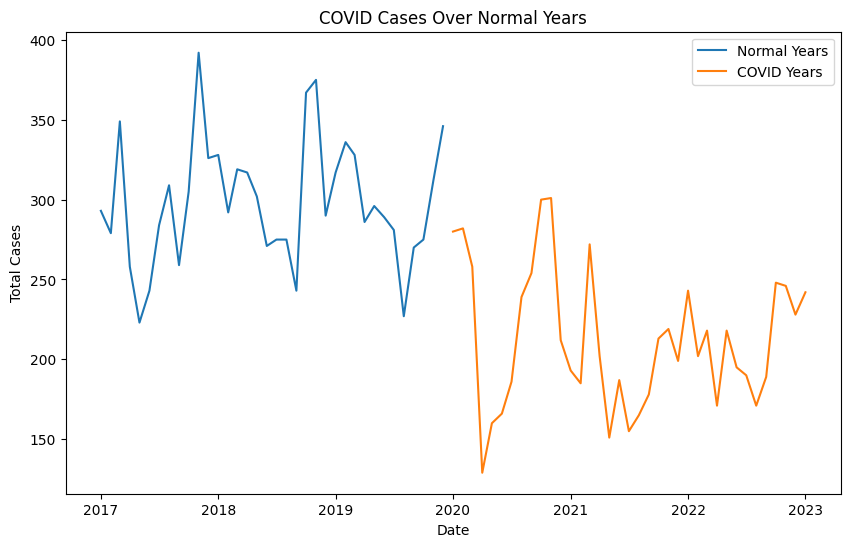

In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/burglary.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df['Month_num'] = df['Month'].dt.month.astype(int)
df['year_num'] = df['Month'].dt.year.astype(int)
# Rename the columns
df = df.rename(columns={'Month_num': 'm', 'year_num': 'year'})

# create 'ds' and convert it to datetime format
df['ds'] = pd.to_datetime(df['m'].astype(str) + '-' + df['year'].astype(str), format='%m-%Y')

# Define the start and end dates of the normal years
normal_start_date = pd.to_datetime('2017-01-01')
normal_end_date = pd.to_datetime('2019-12-31')

# Subset the DataFrame for the normal years
normal_df = df[(df['ds'] >= normal_start_date) & (df['ds'] <= normal_end_date)]

# create y
date_counts = normal_df.groupby('ds').transform('count')
normal_df["y"] = date_counts["year"]

# Subset the DataFrame for the COVID time period
covid_start_date = pd.to_datetime('2020-01-01')
covid_end_date = pd.to_datetime('2023-01-01')
covid_df = df[(df['ds'] >= covid_start_date) & (df['ds'] <= covid_end_date)]

# create y
date_counts = covid_df.groupby('ds').transform('count')
covid_df["y"] = date_counts["year"]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(normal_df['ds'], normal_df['y'], label='Normal Years')
plt.plot(covid_df['ds'], covid_df['y'], label='COVID Years')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.title('COVID Cases Over Normal Years')
plt.legend()
plt.show()

# prophet with imputed data from covid - Per LSOA code

In [ ]:
# Load the data
df = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/burglary.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df['Month_num'] = df['Month'].dt.month.astype(int)
df['year_num'] = df['Month'].dt.year.astype(int)
df = df.rename(columns={'Month_num': 'm', 'year_num': 'year'})

# create 'ds' and convert it to datetime format
df['ds'] = pd.to_datetime(df['m'].astype(str) + '-' + df['year'].astype(str), format='%m-%Y')
df = df[df['ds'] <  pd.to_datetime('2020-01-01')]
print(df.shape)

# Create a list of unique LSOA codes in the data (will be looped over)
lsoa_codes = df['LSOA code'].unique()

# Create an empty DataFrame to store the forecasts
forecast_all = pd.DataFrame()

# Loop over each LSOA code and generate a separate forecast for each one
for lsoa_code in lsoa_codes:
    print(lsoa_code)
    # Filter the data for the current LSOA code
    df_lsoa = df[df['LSOA code'] == lsoa_code].copy().reset_index(drop=True)

    # create y
    date_counts = df_lsoa.groupby('ds').transform('count')
    df_lsoa["y"] = date_counts["year"]

    # Create a new DataFrame that includes all months from 2020-01-01 to 2023-03-01
    new_df2 = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', end='2023-03-01', freq='MS')})

    # Compute the average for each month using data from previous years
    new_df2['y'] = np.nan
    for idx, row in new_df2.iterrows():
        month = row['ds'].month
        avg = df_lsoa[df_lsoa['ds'].dt.month == month]['y'].mean() #* (1 - row['weights'])
        avg = int(avg)
        new_df2.loc[idx, 'y'] = avg
        new_df2.loc[idx, 'LSOA code'] = lsoa_code

    new_df2['y'] = new_df2['y'].astype(int)

    # Create a new DataFrame with expanded rows 
    expanded_df = pd.DataFrame()
    for index, row in new_df2.iterrows():
        rows = pd.DataFrame({'ds': [row['ds']] * row['y'],
                            'y': [row['y']] * row['y'],
                             'LSOA code': [row['LSOA code']] * row['y']})
        expanded_df = pd.concat([expanded_df, rows], ignore_index=True)

    # merge dfs
    imputed_df = pd.concat([df_lsoa, expanded_df[['ds', 'y', 'LSOA code']]], axis=0)
    imputed_df = imputed_df.reset_index(drop=True)

    
    #source from https://facebook.github.io/prophet/docs/quick_start.html#python-api
    #prophet dataframe
    prohpet_df = imputed_df[['ds', 'y']]
    m = Prophet()
    m.fit(prohpet_df)

    # Create a new DataFrame with 3 month forecast
    future = m.make_future_dataframe(periods=3, freq='M')

    # Generate the forecasts for the current LSOA code
    forecast = m.predict(future)

    # Add a column to the forecast DataFrame to indicate the current LSOA code
    forecast['LSOA code'] = lsoa_code

    # Append the forecasts for the current LSOA code to the overall forecast DataFrame
    forecast_all = forecast_all.append(forecast)

# Write the forecast DataFrame to a CSV file
forecast_all.to_csv('my_forecasts.csv', index=False)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/0txywjz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/fh_kzh6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99000', 'data', 'file=/tmp/tmpspuvbk2l/0txywjz_.json', 'init=/tmp/tmpspuvbk2l/fh_kzh6q.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelsa57ttyb/prophet_model-20230519112042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


(35861, 16)
E01000248


11:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


E01000249


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/tglzus3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/d6bupoep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65414', 'data', 'file=/tmp/tmpspuvbk2l/tglzus3a.json', 'init=/tmp/tmpspuvbk2l/d6bupoep.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modellj74iqz4/prophet_model-20230519112042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000254


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rs2j_94d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/bdc7zgwn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6433', 'data', 'file=/tmp/tmpspuvbk2l/rs2j_94d.json', 'init=/tmp/tmpspuvbk2l/bdc7zgwn.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model1movkh6b/prophet_model-20230519112043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: Futur

E01000292


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5m8fk6ku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/pf3tcd53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77107', 'data', 'file=/tmp/tmpspuvbk2l/5m8fk6ku.json', 'init=/tmp/tmpspuvbk2l/pf3tcd53.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelwv2jqvnl/prophet_model-20230519112043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: Futu

E01000293


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/nr6eyrhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3wejfny5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32090', 'data', 'file=/tmp/tmpspuvbk2l/nr6eyrhu.json', 'init=/tmp/tmpspuvbk2l/3wejfny5.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model1fw6cqyp/prophet_model-20230519112044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000167


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/gcnh400s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/tzg4zr1l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19975', 'data', 'file=/tmp/tmpspuvbk2l/gcnh400s.json', 'init=/tmp/tmpspuvbk2l/tzg4zr1l.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelwvvz90jl/prophet_model-20230519112044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000251


11:20:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ia8pzo7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/p3_yv6ud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34583', 'data', 'file=/tmp/tmpspuvbk2l/ia8pzo7i.json', 'init=/tmp/tmpspuvbk2l/p3_yv6ud.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelxgme_tw7/prophet_model-20230519112044.csv', 'method=optimize', '

E01000252


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/hwyscm30.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3zxw7cll.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11321', 'data', 'file=/tmp/tmpspuvbk2l/hwyscm30.json', 'init=/tmp/tmpspuvbk2l/3zxw7cll.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model128lkxah/prophet_model-20230519112045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000166


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/2smnpx2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rdodzezu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74932', 'data', 'file=/tmp/tmpspuvbk2l/2smnpx2x.json', 'init=/tmp/tmpspuvbk2l/rdodzezu.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modellrn8q83a/prophet_model-20230519112045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000168


11:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/mjq673up.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9q4h4zsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78209', 'data', 'file=/tmp/tmpspuvbk2l/mjq673up.json', 'init=/tmp/tmpspuvbk2l/9q4h4zsu.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeledj_j66w/prophet_model-20230519112045.csv', 'method=optimize', '

E01000169


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/4nu0p_yf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/s339sn4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13672', 'data', 'file=/tmp/tmpspuvbk2l/4nu0p_yf.json', 'init=/tmp/tmpspuvbk2l/s339sn4i.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeluysrixfz/prophet_model-20230519112045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000285


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/fy9rw3ip.json


E01000289


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/1amk4hey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29381', 'data', 'file=/tmp/tmpspuvbk2l/fy9rw3ip.json', 'init=/tmp/tmpspuvbk2l/1amk4hey.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model1i1p4tl5/prophet_model-20230519112046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000291


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/yfujpjoo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ptu9qthb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15473', 'data', 'file=/tmp/tmpspuvbk2l/yfujpjoo.json', 'init=/tmp/tmpspuvbk2l/ptu9qthb.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model0qm7qpve/prophet_model-20230519112046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000267


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/sk5gezjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1562', 'data', 'file=/tmp/tmpspuvbk2l/hsggmsu9.json', 'init=/tmp/tmpspuvbk2l/sk5gezjt.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model8_eedygd/prophet_model-20230519112047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seas

E01000268


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ywatbgdz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/b11dfp8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73185', 'data', 'file=/tmp/tmpspuvbk2l/ywatbgdz.json', 'init=/tmp/tmpspuvbk2l/b11dfp8l.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelgf1jkpwf/prophet_model-20230519112047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000270


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/41jik9g9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98056', 'data', 'file=/tmp/tmpspuvbk2l/yvslw2rt.json', 'init=/tmp/tmpspuvbk2l/41jik9g9.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modely8833hvi/prophet_model-20230519112047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000170


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/l8ye7ib_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/pbb1x_5z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47690', 'data', 'file=/tmp/tmpspuvbk2l/l8ye7ib_.json', 'init=/tmp/tmpspuvbk2l/pbb1x_5z.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model3x5m4xp2/prophet_model-20230519112048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000171


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/enht8e8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63354', 'data', 'file=/tmp/tmpspuvbk2l/rs1_148z.json', 'init=/tmp/tmpspuvbk2l/enht8e8g.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeloi6weqh0/prophet_model-20230519112048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000173


11:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9rodos9e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5a6lz4jp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23303', 'data', 'file=/tmp/tmpspuvbk2l/9rodos9e.json', 'init=/tmp/tmpspuvbk2l/5a6lz4jp.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model8ejdotdb/prophet_model-20230519112049.csv', 'method=optimize', '

E01000174


11:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5no_2saa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/j16es1mx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91968', 'data', 'file=/tmp/tmpspuvbk2l/5no_2saa.json', 'init=/tmp/tmpspuvbk2l/j16es1mx.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelz3kchl54/prophet_model-20230519112049.csv', 'method=optimize', '

E01000228


11:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ehjatybd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/j57q7zh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64148', 'data', 'file=/tmp/tmpspuvbk2l/ehjatybd.json', 'init=/tmp/tmpspuvbk2l/j57q7zh5.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelublf_56_/prophet_model-20230519112050.csv', 'method=optimize', '

E01000253


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/8i7h8osl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/dhuivn6z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96604', 'data', 'file=/tmp/tmpspuvbk2l/8i7h8osl.json', 'init=/tmp/tmpspuvbk2l/dhuivn6z.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelfseti1is/prophet_model-20230519112050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000280


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ligm6e8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/cd564o2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18634', 'data', 'file=/tmp/tmpspuvbk2l/ligm6e8t.json', 'init=/tmp/tmpspuvbk2l/cd564o2y.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelpsqfs5q5/prophet_model-20230519112050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:50 - cmdstanpy - I

E01000286


11:20:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/q0i4180e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/vmixrh2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50241', 'data', 'file=/tmp/tmpspuvbk2l/q0i4180e.json', 'init=/tmp/tmpspuvbk2l/vmixrh2k.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelxzocj56d/prophet_model-20230519112050.csv', 'method=optimize', '

E01000290


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/6awewebg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/7qucxmra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2852', 'data', 'file=/tmp/tmpspuvbk2l/6awewebg.json', 'init=/tmp/tmpspuvbk2l/7qucxmra.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelo4_rp25f/prophet_model-20230519112051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmds

E01000271


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9xt8vj0t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/qgbunim0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31763', 'data', 'file=/tmp/tmpspuvbk2l/9xt8vj0t.json', 'init=/tmp/tmpspuvbk2l/qgbunim0.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelgim2x88g/prophet_model-20230519112051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000272


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/bvk2lwc4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ltn2a3t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26037', 'data', 'file=/tmp/tmpspuvbk2l/bvk2lwc4.json', 'init=/tmp/tmpspuvbk2l/ltn2a3t0.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modellha0f182/prophet_model-20230519112051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000273


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ptuvz4ei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/dewgc6_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69660', 'data', 'file=/tmp/tmpspuvbk2l/ptuvz4ei.json', 'init=/tmp/tmpspuvbk2l/dewgc6_x.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model_4ls8oz6/prophet_model-20230519112052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000282


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/t7yu5ebw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/u8ab6u97.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63763', 'data', 'file=/tmp/tmpspuvbk2l/t7yu5ebw.json', 'init=/tmp/tmpspuvbk2l/u8ab6u97.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model8o5p9fwu/prophet_model-20230519112052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:52 - cmdstanpy - I

E01000116


11:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/fycaiuor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3yrep0t4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4361', 'data', 'file=/tmp/tmpspuvbk2l/fycaiuor.json', 'init=/tmp/tmpspuvbk2l/3yrep0t4.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelxscfv2ig/prophet_model-20230519112052.csv', 'method=optimize', 'a

E01000120


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/d5p5coo4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/xbvxd_yt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69693', 'data', 'file=/tmp/tmpspuvbk2l/d5p5coo4.json', 'init=/tmp/tmpspuvbk2l/xbvxd_yt.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeli4r9pli5/prophet_model-20230519112052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000122


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/byfwxafx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/z2yurwym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21191', 'data', 'file=/tmp/tmpspuvbk2l/byfwxafx.json', 'init=/tmp/tmpspuvbk2l/z2yurwym.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model1nnvxnqx/prophet_model-20230519112053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000117


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/gio47mmc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/s2wc7940.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23808', 'data', 'file=/tmp/tmpspuvbk2l/gio47mmc.json', 'init=/tmp/tmpspuvbk2l/s2wc7940.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model0qv63ek3/prophet_model-20230519112053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000118


11:20:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/4dfc1na3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/2x9862qy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19776', 'data', 'file=/tmp/tmpspuvbk2l/4dfc1na3.json', 'init=/tmp/tmpspuvbk2l/2x9862qy.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model4mgidmox/prophet_model-20230519112053.csv', 'method=optimize', '

E01000121


11:20:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/moet3v_h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/8_hynm7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47081', 'data', 'file=/tmp/tmpspuvbk2l/moet3v_h.json', 'init=/tmp/tmpspuvbk2l/8_hynm7m.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelrle9mrl9/prophet_model-20230519112054.csv', 'method=optimize', '

E01000123


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/tk0k2tcf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/gwg6l8rc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76603', 'data', 'file=/tmp/tmpspuvbk2l/tk0k2tcf.json', 'init=/tmp/tmpspuvbk2l/gwg6l8rc.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelfhxalx_a/prophet_model-20230519112054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000124


11:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/y5f_on7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/hj5zm8v3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75421', 'data', 'file=/tmp/tmpspuvbk2l/y5f_on7x.json', 'init=/tmp/tmpspuvbk2l/hj5zm8v3.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model6gmuy96v/prophet_model-20230519112054.csv', 'method=optimize', '

E01000266


11:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/aubjm1io.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/qwyjbohi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23386', 'data', 'file=/tmp/tmpspuvbk2l/aubjm1io.json', 'init=/tmp/tmpspuvbk2l/qwyjbohi.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelrs30_d6r/prophet_model-20230519112054.csv', 'method=optimize', '

E01000274


11:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/wjsh5m66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/lr703j0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85159', 'data', 'file=/tmp/tmpspuvbk2l/wjsh5m66.json', 'init=/tmp/tmpspuvbk2l/lr703j0u.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeltatnkpu4/prophet_model-20230519112055.csv', 'method=optimize', '

E01000320


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/052fd8br.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/hwuwb2z8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64054', 'data', 'file=/tmp/tmpspuvbk2l/052fd8br.json', 'init=/tmp/tmpspuvbk2l/hwuwb2z8.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelnfvtdvgz/prophet_model-20230519112055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000322


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/imbireg7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/gyx8_635.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94890', 'data', 'file=/tmp/tmpspuvbk2l/imbireg7.json', 'init=/tmp/tmpspuvbk2l/gyx8_635.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeld3oi162d/prophet_model-20230519112055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:55 - cmdstanpy - I

E01000275


11:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_smm_o1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/bhye6op9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30973', 'data', 'file=/tmp/tmpspuvbk2l/_smm_o1p.json', 'init=/tmp/tmpspuvbk2l/bhye6op9.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modell0nu6s0l/prophet_model-20230519112056.csv', 'method=optimize', '

E01000277


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/t4x2rtep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/q9sekmjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40120', 'data', 'file=/tmp/tmpspuvbk2l/t4x2rtep.json', 'init=/tmp/tmpspuvbk2l/q9sekmjt.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model76n_wicg/prophet_model-20230519112056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000283


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/oe_jaeps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/jqyh8_64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18396', 'data', 'file=/tmp/tmpspuvbk2l/oe_jaeps.json', 'init=/tmp/tmpspuvbk2l/jqyh8_64.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelknlyg5jn/prophet_model-20230519112056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000284


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/jhz9bzaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/fm7itc6m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95133', 'data', 'file=/tmp/tmpspuvbk2l/jhz9bzaa.json', 'init=/tmp/tmpspuvbk2l/fm7itc6m.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelj81r8b1h/prophet_model-20230519112056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000321


11:20:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/45ota1om.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/dodfeujw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14053', 'data', 'file=/tmp/tmpspuvbk2l/45ota1om.json', 'init=/tmp/tmpspuvbk2l/dodfeujw.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeltpwbrasv/prophet_model-20230519112057.csv', 'method=optimize', '

E01000229


11:20:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ya30vd88.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/bgmb2kiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29284', 'data', 'file=/tmp/tmpspuvbk2l/ya30vd88.json', 'init=/tmp/tmpspuvbk2l/bgmb2kiq.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modellgexzaqz/prophet_model-20230519112057.csv', 'method=optimize', '

E01000230


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/u39rhh3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rhuaz4ki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7906', 'data', 'file=/tmp/tmpspuvbk2l/u39rhh3f.json', 'init=/tmp/tmpspuvbk2l/rhuaz4ki.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeliyqeo7mm/prophet_model-20230519112057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmds

E01000231


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/wip4f3rj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/aqzse2t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46296', 'data', 'file=/tmp/tmpspuvbk2l/wip4f3rj.json', 'init=/tmp/tmpspuvbk2l/aqzse2t6.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelt5dpp_h3/prophet_model-20230519112058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:58 - cmdstanpy - I

E01000232


11:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/elza1kau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/yxiggd4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50122', 'data', 'file=/tmp/tmpspuvbk2l/elza1kau.json', 'init=/tmp/tmpspuvbk2l/yxiggd4u.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeluup798su/prophet_model-20230519112058.csv', 'method=optimize', '

E01000233


11:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/veaswkjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/d903vxny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6767', 'data', 'file=/tmp/tmpspuvbk2l/veaswkjb.json', 'init=/tmp/tmpspuvbk2l/d903vxny.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeletignad4/prophet_model-20230519112058.csv', 'method=optimize', 'a

E01000186


11:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/wqg9o0hz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/nb3gcege.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13692', 'data', 'file=/tmp/tmpspuvbk2l/wqg9o0hz.json', 'init=/tmp/tmpspuvbk2l/nb3gcege.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelt0re6g7q/prophet_model-20230519112059.csv', 'method=optimize', '

E01000187


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


E01000188


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ndgibjrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9xs_tfpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6359', 'data', 'file=/tmp/tmpspuvbk2l/ndgibjrd.json', 'init=/tmp/tmpspuvbk2l/9xs_tfpb.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelcwm3anl1/prophet_model-20230519112059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seaso

E01000189


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_7hpg26i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76653', 'data', 'file=/tmp/tmpspuvbk2l/boiadb3s.json', 'init=/tmp/tmpspuvbk2l/_7hpg26i.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelpsadd989/prophet_model-20230519112059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000190


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/f7cx23ge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9666', 'data', 'file=/tmp/tmpspuvbk2l/tlvj_hx4.json', 'init=/tmp/tmpspuvbk2l/f7cx23ge.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeli6cnni_c/prophet_model-20230519112100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seas

E01000191


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/itjit97u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56678', 'data', 'file=/tmp/tmpspuvbk2l/w2m7dlyg.json', 'init=/tmp/tmpspuvbk2l/itjit97u.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modela7q8gd2g/prophet_model-20230519112100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000158


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/u378hb7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56606', 'data', 'file=/tmp/tmpspuvbk2l/07gwxmpq.json', 'init=/tmp/tmpspuvbk2l/u378hb7b.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelp_5nztsy/prophet_model-20230519112100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000159


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/7cs9bxly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31100', 'data', 'file=/tmp/tmpspuvbk2l/6zon0jmz.json', 'init=/tmp/tmpspuvbk2l/7cs9bxly.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelpwglq_0n/prophet_model-20230519112101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000160


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/q4jzm9kr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/z9l58tuw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58353', 'data', 'file=/tmp/tmpspuvbk2l/q4jzm9kr.json', 'init=/tmp/tmpspuvbk2l/z9l58tuw.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model1oqm2eh6/prophet_model-20230519112101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000161


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/heora_tk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56948', 'data', 'file=/tmp/tmpspuvbk2l/vhtuec3f.json', 'init=/tmp/tmpspuvbk2l/heora_tk.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modellkubi9_o/prophet_model-20230519112102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000162


11:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/b2gd9n1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/krl06e18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4745', 'data', 'file=/tmp/tmpspuvbk2l/b2gd9n1g.json', 'init=/tmp/tmpspuvbk2l/krl06e18.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelkbxxey51/prophet_model-20230519112102.csv', 'method=optimize', 'a

E01000324


11:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/j2nkwgqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/pisc08fo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65459', 'data', 'file=/tmp/tmpspuvbk2l/j2nkwgqk.json', 'init=/tmp/tmpspuvbk2l/pisc08fo.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelt27a0znf/prophet_model-20230519112103.csv', 'method=optimize', '

E01000256


11:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rycq1834.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/yyq62ez4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23879', 'data', 'file=/tmp/tmpspuvbk2l/rycq1834.json', 'init=/tmp/tmpspuvbk2l/yyq62ez4.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeltkxa6qj0/prophet_model-20230519112103.csv', 'method=optimize', '

E01000258


11:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/7tp2c02z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3ew9ntur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15977', 'data', 'file=/tmp/tmpspuvbk2l/7tp2c02z.json', 'init=/tmp/tmpspuvbk2l/3ew9ntur.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeluupuswln/prophet_model-20230519112103.csv', 'method=optimize', '

E01000263


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/o08lm90h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/mohdtl36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85664', 'data', 'file=/tmp/tmpspuvbk2l/o08lm90h.json', 'init=/tmp/tmpspuvbk2l/mohdtl36.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelouvxpiij/prophet_model-20230519112104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:04 - cmdstanpy - I

E01000264


11:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ex9bqb0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/695of38n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7045', 'data', 'file=/tmp/tmpspuvbk2l/ex9bqb0k.json', 'init=/tmp/tmpspuvbk2l/695of38n.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modellmcrgn9h/prophet_model-20230519112104.csv', 'method=optimize', 'a

E01000255


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ir0z5bdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/fv3_cjjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60387', 'data', 'file=/tmp/tmpspuvbk2l/ir0z5bdy.json', 'init=/tmp/tmpspuvbk2l/fv3_cjjx.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model30ml0aex/prophet_model-20230519112104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000257


11:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_j1gyz_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/x2ieqzd9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23753', 'data', 'file=/tmp/tmpspuvbk2l/_j1gyz_5.json', 'init=/tmp/tmpspuvbk2l/x2ieqzd9.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelb8abnbc3/prophet_model-20230519112104.csv', 'method=optimize', '

E01000261


11:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/r4ynmb2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/h_d9ogqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6692', 'data', 'file=/tmp/tmpspuvbk2l/r4ynmb2g.json', 'init=/tmp/tmpspuvbk2l/h_d9ogqv.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelcqpenunz/prophet_model-20230519112105.csv', 'method=optimize', 'a

E01000262


11:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/mdffyoxw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/53nfblbe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9004', 'data', 'file=/tmp/tmpspuvbk2l/mdffyoxw.json', 'init=/tmp/tmpspuvbk2l/53nfblbe.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelqwjqq1le/prophet_model-20230519112105.csv', 'method=optimize', 'a

E01000193


11:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/0k1if9nq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/nlswoe_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27224', 'data', 'file=/tmp/tmpspuvbk2l/0k1if9nq.json', 'init=/tmp/tmpspuvbk2l/nlswoe_2.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model46g84zy5/prophet_model-20230519112105.csv', 'method=optimize', '

E01000194


11:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/2d7909e2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ktb6vkyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71257', 'data', 'file=/tmp/tmpspuvbk2l/2d7909e2.json', 'init=/tmp/tmpspuvbk2l/ktb6vkyz.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelwukct4h5/prophet_model-20230519112106.csv', 'method=optimize', '

E01000226


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/us3oives.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/fic7lyd3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60168', 'data', 'file=/tmp/tmpspuvbk2l/us3oives.json', 'init=/tmp/tmpspuvbk2l/fic7lyd3.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model503blx3h/prophet_model-20230519112106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:06 - cmdstanpy - I

E01000227


11:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/jm6zcb_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/w5cd4ihe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72134', 'data', 'file=/tmp/tmpspuvbk2l/jm6zcb_0.json', 'init=/tmp/tmpspuvbk2l/w5cd4ihe.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model_j1cgoj3/prophet_model-20230519112106.csv', 'method=optimize', '

E01000299


11:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/lgvfjuqr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/q2ng9e5z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21054', 'data', 'file=/tmp/tmpspuvbk2l/lgvfjuqr.json', 'init=/tmp/tmpspuvbk2l/q2ng9e5z.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelv8755xm0/prophet_model-20230519112107.csv', 'method=optimize', '

E01000302


11:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/0mvajb3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/i3zmj4pt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79098', 'data', 'file=/tmp/tmpspuvbk2l/0mvajb3e.json', 'init=/tmp/tmpspuvbk2l/i3zmj4pt.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeltfrbg1e_/prophet_model-20230519112107.csv', 'method=optimize', '

E01000317


11:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ct7zealk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3e671eoo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56217', 'data', 'file=/tmp/tmpspuvbk2l/ct7zealk.json', 'init=/tmp/tmpspuvbk2l/3e671eoo.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelbbotfp1r/prophet_model-20230519112107.csv', 'method=optimize', '

E01000318


11:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_0zafsp0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9sbkwapj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92395', 'data', 'file=/tmp/tmpspuvbk2l/_0zafsp0.json', 'init=/tmp/tmpspuvbk2l/9sbkwapj.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeltd7qy6i_/prophet_model-20230519112107.csv', 'method=optimize', '

E01000323


11:21:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/k5wh0183.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/k5tm4j3o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76052', 'data', 'file=/tmp/tmpspuvbk2l/k5wh0183.json', 'init=/tmp/tmpspuvbk2l/k5tm4j3o.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model7sn3wpzt/prophet_model-20230519112108.csv', 'method=optimize', '

E01000278


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/mnoyo_w1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ucdq_34n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6242', 'data', 'file=/tmp/tmpspuvbk2l/mnoyo_w1.json', 'init=/tmp/tmpspuvbk2l/ucdq_34n.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelmng79l1t/prophet_model-20230519112108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:08 - cmdstanpy - IN

E01000301


11:21:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/v5_9b0ua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9s8d3bdl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79539', 'data', 'file=/tmp/tmpspuvbk2l/v5_9b0ua.json', 'init=/tmp/tmpspuvbk2l/9s8d3bdl.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model9qnhwz2j/prophet_model-20230519112108.csv', 'method=optimize', '

E01000303


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/atzrk9tt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/wjjyz_uq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18200', 'data', 'file=/tmp/tmpspuvbk2l/atzrk9tt.json', 'init=/tmp/tmpspuvbk2l/wjjyz_uq.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modellmt1gyyu/prophet_model-20230519112109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000304


11:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9dr_igc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ur7l_m71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62870', 'data', 'file=/tmp/tmpspuvbk2l/9dr_igc_.json', 'init=/tmp/tmpspuvbk2l/ur7l_m71.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model5n4mt4ng/prophet_model-20230519112109.csv', 'method=optimize', '

E01000130


11:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/qnvop2w5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/kkeu1dvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55531', 'data', 'file=/tmp/tmpspuvbk2l/qnvop2w5.json', 'init=/tmp/tmpspuvbk2l/kkeu1dvz.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelvar60jaa/prophet_model-20230519112109.csv', 'method=optimize', '

E01000234


11:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9teulwnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/7c7h771y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30752', 'data', 'file=/tmp/tmpspuvbk2l/9teulwnr.json', 'init=/tmp/tmpspuvbk2l/7c7h771y.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelaq0b8az1/prophet_model-20230519112110.csv', 'method=optimize', '

E01000235


11:21:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/scbxmmdx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/uiv2knua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21886', 'data', 'file=/tmp/tmpspuvbk2l/scbxmmdx.json', 'init=/tmp/tmpspuvbk2l/uiv2knua.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model3i940fyu/prophet_model-20230519112110.csv', 'method=optimize', '

E01000156


11:21:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/25eijdte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/l42tqvt4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97289', 'data', 'file=/tmp/tmpspuvbk2l/25eijdte.json', 'init=/tmp/tmpspuvbk2l/l42tqvt4.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelvufptktg/prophet_model-20230519112110.csv', 'method=optimize', '

E01000157


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/imeg1yxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/2dx9q8qp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58313', 'data', 'file=/tmp/tmpspuvbk2l/imeg1yxu.json', 'init=/tmp/tmpspuvbk2l/2dx9q8qp.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelk_n2ae9c/prophet_model-20230519112111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000163


11:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/df_bzo31.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_72bkppk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70711', 'data', 'file=/tmp/tmpspuvbk2l/df_bzo31.json', 'init=/tmp/tmpspuvbk2l/_72bkppk.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model0rx52l2b/prophet_model-20230519112111.csv', 'method=optimize', '

E01000164


11:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/dva1owcu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/laalqsfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78476', 'data', 'file=/tmp/tmpspuvbk2l/dva1owcu.json', 'init=/tmp/tmpspuvbk2l/laalqsfn.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelryd94w68/prophet_model-20230519112111.csv', 'method=optimize', '

E01000315


11:21:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/aeb8j_9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/e91t67_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68740', 'data', 'file=/tmp/tmpspuvbk2l/aeb8j_9w.json', 'init=/tmp/tmpspuvbk2l/e91t67_1.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelr1wcwxbw/prophet_model-20230519112111.csv', 'method=optimize', '

E01000197


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/s99c_i1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/n6x98z2d.json


E01000295


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18351', 'data', 'file=/tmp/tmpspuvbk2l/s99c_i1n.json', 'init=/tmp/tmpspuvbk2l/n6x98z2d.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelkgiiasok/prophet_model-20230519112112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

E01000296


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/sdy3fo52.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/b32odfns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11581', 'data', 'file=/tmp/tmpspuvbk2l/sdy3fo52.json', 'init=/tmp/tmpspuvbk2l/b32odfns.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelv5cwvw_v/prophet_model-20230519112112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000298


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/8akrlg12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4204', 'data', 'file=/tmp/tmpspuvbk2l/i1tz4qhf.json', 'init=/tmp/tmpspuvbk2l/8akrlg12.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelddesqb4r/prophet_model-20230519112113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seas

E01000131


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/m0rwd1qe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19284', 'data', 'file=/tmp/tmpspuvbk2l/uahqrel1.json', 'init=/tmp/tmpspuvbk2l/m0rwd1qe.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelj8bnq2o7/prophet_model-20230519112113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000134


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31359', 'data', 'file=/tmp/tmpspuvbk2l/208n0cqx.json', 'init=/tmp/tmpspuvbk2l/qb568m_w.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeltxf8k5af/prophet_model-20230519112114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

E01000199


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/eot7tbbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9021', 'data', 'file=/tmp/tmpspuvbk2l/8kp1b2ta.json', 'init=/tmp/tmpspuvbk2l/eot7tbbp.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelxd3exs1z/prophet_model-20230519112114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seas

E01000204


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/muryxmv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/s3r8fjki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83561', 'data', 'file=/tmp/tmpspuvbk2l/muryxmv3.json', 'init=/tmp/tmpspuvbk2l/s3r8fjki.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modele3i96kyi/prophet_model-20230519112114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000259


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9ushva77.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3tm7mklm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91242', 'data', 'file=/tmp/tmpspuvbk2l/9ushva77.json', 'init=/tmp/tmpspuvbk2l/3tm7mklm.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model4xpnsq8b/prophet_model-20230519112115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000260


11:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ettg3nev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_uo92f7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21895', 'data', 'file=/tmp/tmpspuvbk2l/ettg3nev.json', 'init=/tmp/tmpspuvbk2l/_uo92f7f.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeltqpznfh_/prophet_model-20230519112115.csv', 'method=optimize', '

E01000126


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3g4nxjn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/7cmn0e3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68123', 'data', 'file=/tmp/tmpspuvbk2l/3g4nxjn_.json', 'init=/tmp/tmpspuvbk2l/7cmn0e3h.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model2qa561yp/prophet_model-20230519112116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000151


11:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/x1hyx4g_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/z9ltauca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12258', 'data', 'file=/tmp/tmpspuvbk2l/x1hyx4g_.json', 'init=/tmp/tmpspuvbk2l/z9ltauca.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model7sakc3q9/prophet_model-20230519112116.csv', 'method=optimize', '

E01000152


11:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/mwhbrcgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ywssfrq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23602', 'data', 'file=/tmp/tmpspuvbk2l/mwhbrcgy.json', 'init=/tmp/tmpspuvbk2l/ywssfrq7.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model7e1uutb4/prophet_model-20230519112116.csv', 'method=optimize', '

E01000153


11:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9j1gf5wj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/tokbw9li.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40516', 'data', 'file=/tmp/tmpspuvbk2l/9j1gf5wj.json', 'init=/tmp/tmpspuvbk2l/tokbw9li.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model3n72z32x/prophet_model-20230519112117.csv', 'method=optimize', '

E01000154


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/qj3nmzus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/e20ftuzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82686', 'data', 'file=/tmp/tmpspuvbk2l/qj3nmzus.json', 'init=/tmp/tmpspuvbk2l/e20ftuzv.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modellb_ga4yu/prophet_model-20230519112117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000176


11:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rqp289mi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/dnm9paby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15722', 'data', 'file=/tmp/tmpspuvbk2l/rqp289mi.json', 'init=/tmp/tmpspuvbk2l/dnm9paby.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelcy5dc5xf/prophet_model-20230519112117.csv', 'method=optimize', '

E01000178


11:21:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/utoso9ow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/w1eu3hd1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69249', 'data', 'file=/tmp/tmpspuvbk2l/utoso9ow.json', 'init=/tmp/tmpspuvbk2l/w1eu3hd1.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelc91riuak/prophet_model-20230519112118.csv', 'method=optimize', '

E01000297


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/gg2rpay_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/1r_7vmka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66663', 'data', 'file=/tmp/tmpspuvbk2l/gg2rpay_.json', 'init=/tmp/tmpspuvbk2l/1r_7vmka.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model2e8xm_kz/prophet_model-20230519112118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000316


11:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5hx2mjow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ry_90sz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10798', 'data', 'file=/tmp/tmpspuvbk2l/5hx2mjow.json', 'init=/tmp/tmpspuvbk2l/ry_90sz0.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelhb9gw2c8/prophet_model-20230519112118.csv', 'method=optimize', '

E01000319


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/7h8ee078.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/qpku9e3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2772', 'data', 'file=/tmp/tmpspuvbk2l/7h8ee078.json', 'init=/tmp/tmpspuvbk2l/qpku9e3f.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelaeoc8uy_/prophet_model-20230519112118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmds

E01000196


11:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/v4i5zqq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ssvet94a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71907', 'data', 'file=/tmp/tmpspuvbk2l/v4i5zqq3.json', 'init=/tmp/tmpspuvbk2l/ssvet94a.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeluda9334o/prophet_model-20230519112119.csv', 'method=optimize', '

E01000200


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/vty76q4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/i0l3p207.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93671', 'data', 'file=/tmp/tmpspuvbk2l/vty76q4h.json', 'init=/tmp/tmpspuvbk2l/i0l3p207.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelu8bk7ndf/prophet_model-20230519112119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000201


11:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/mmymd0tw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/hmgde_a8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20272', 'data', 'file=/tmp/tmpspuvbk2l/mmymd0tw.json', 'init=/tmp/tmpspuvbk2l/hmgde_a8.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeloijll2ou/prophet_model-20230519112119.csv', 'method=optimize', '

E01000202


11:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9o2_os36.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/f_vh757h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43074', 'data', 'file=/tmp/tmpspuvbk2l/9o2_os36.json', 'init=/tmp/tmpspuvbk2l/f_vh757h.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelicueiokw/prophet_model-20230519112120.csv', 'method=optimize', '

E01000203


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/0hlxies7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ki4o3j3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64011', 'data', 'file=/tmp/tmpspuvbk2l/0hlxies7.json', 'init=/tmp/tmpspuvbk2l/ki4o3j3n.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelh_mkoos5/prophet_model-20230519112120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000177


11:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/lmnpy51t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/gy7hnf9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91624', 'data', 'file=/tmp/tmpspuvbk2l/lmnpy51t.json', 'init=/tmp/tmpspuvbk2l/gy7hnf9l.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelhsl_qi1z/prophet_model-20230519112120.csv', 'method=optimize', '

E01000179


11:21:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/uphl7asw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/t5466bnz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98321', 'data', 'file=/tmp/tmpspuvbk2l/uphl7asw.json', 'init=/tmp/tmpspuvbk2l/t5466bnz.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model2fom2ovz/prophet_model-20230519112121.csv', 'method=optimize', '

E01000180


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/v4zk04g2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/n51y_rcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32381', 'data', 'file=/tmp/tmpspuvbk2l/v4zk04g2.json', 'init=/tmp/tmpspuvbk2l/n51y_rcq.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelrshorpyq/prophet_model-20230519112121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000181


11:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/gzclbgcc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/uro_5_rp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81292', 'data', 'file=/tmp/tmpspuvbk2l/gzclbgcc.json', 'init=/tmp/tmpspuvbk2l/uro_5_rp.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model1fzl5rzf/prophet_model-20230519112121.csv', 'method=optimize', '

E01000182


11:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/oywax5pn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/itrabkh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95508', 'data', 'file=/tmp/tmpspuvbk2l/oywax5pn.json', 'init=/tmp/tmpspuvbk2l/itrabkh5.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelf6k8fm4t/prophet_model-20230519112122.csv', 'method=optimize', '

E01000155


11:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/sceibbca.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/s3ivrevd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36101', 'data', 'file=/tmp/tmpspuvbk2l/sceibbca.json', 'init=/tmp/tmpspuvbk2l/s3ivrevd.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelk6_2y_td/prophet_model-20230519112122.csv', 'method=optimize', '

E01033572


11:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/1scre00g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/lx9u2fh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22210', 'data', 'file=/tmp/tmpspuvbk2l/1scre00g.json', 'init=/tmp/tmpspuvbk2l/lx9u2fh0.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modellx3vmwjg/prophet_model-20230519112122.csv', 'method=optimize', '

E01000239


11:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/6pow6nv2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/k66qen4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27394', 'data', 'file=/tmp/tmpspuvbk2l/6pow6nv2.json', 'init=/tmp/tmpspuvbk2l/k66qen4s.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelbvqm0hhw/prophet_model-20230519112122.csv', 'method=optimize', '

E01000240


11:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5dtemfh3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rot6owtc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36114', 'data', 'file=/tmp/tmpspuvbk2l/5dtemfh3.json', 'init=/tmp/tmpspuvbk2l/rot6owtc.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelennib3sl/prophet_model-20230519112123.csv', 'method=optimize', '

E01000241


11:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/cmdro0e7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/v_fjnugh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71087', 'data', 'file=/tmp/tmpspuvbk2l/cmdro0e7.json', 'init=/tmp/tmpspuvbk2l/v_fjnugh.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model3eoo0xam/prophet_model-20230519112123.csv', 'method=optimize', '

E01000237


11:21:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/os8g_2kn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/y6wymxsk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83686', 'data', 'file=/tmp/tmpspuvbk2l/os8g_2kn.json', 'init=/tmp/tmpspuvbk2l/y6wymxsk.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelzi_t9_ox/prophet_model-20230519112123.csv', 'method=optimize', '

E01000242


11:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/8nup45pg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ovcbhx2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61953', 'data', 'file=/tmp/tmpspuvbk2l/8nup45pg.json', 'init=/tmp/tmpspuvbk2l/ovcbhx2z.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model5agifkfh/prophet_model-20230519112124.csv', 'method=optimize', '

E01000244


11:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rr1s72m_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/qxxhlpnl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37733', 'data', 'file=/tmp/tmpspuvbk2l/rr1s72m_.json', 'init=/tmp/tmpspuvbk2l/qxxhlpnl.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelng14hkpr/prophet_model-20230519112124.csv', 'method=optimize', '

E01000245


11:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/irbe367u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/7dt6kes7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7353', 'data', 'file=/tmp/tmpspuvbk2l/irbe367u.json', 'init=/tmp/tmpspuvbk2l/7dt6kes7.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelt1sog53e/prophet_model-20230519112124.csv', 'method=optimize', 'a

E01000183


11:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/iqksnr4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5apj0ito.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11822', 'data', 'file=/tmp/tmpspuvbk2l/iqksnr4j.json', 'init=/tmp/tmpspuvbk2l/5apj0ito.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelxyy4ve31/prophet_model-20230519112125.csv', 'method=optimize', '

E01000207


11:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


E01000208


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9az1kgxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ul_w8lvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63167', 'data', 'file=/tmp/tmpspuvbk2l/9az1kgxd.json', 'init=/tmp/tmpspuvbk2l/ul_w8lvt.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelh_tpyodx/prophet_model-20230519112125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000210


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/zi5t0nj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3gwbq4zm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20566', 'data', 'file=/tmp/tmpspuvbk2l/zi5t0nj6.json', 'init=/tmp/tmpspuvbk2l/3gwbq4zm.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model1k59po38/prophet_model-20230519112126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000213


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/a1s7_mbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/s_cji1ri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25646', 'data', 'file=/tmp/tmpspuvbk2l/a1s7_mbd.json', 'init=/tmp/tmpspuvbk2l/s_cji1ri.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelv5yo_dgw/prophet_model-20230519112126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000236


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5b6cxkwq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/i2wbmuj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50612', 'data', 'file=/tmp/tmpspuvbk2l/5b6cxkwq.json', 'init=/tmp/tmpspuvbk2l/i2wbmuj2.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelfjap_f43/prophet_model-20230519112127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version.

E01000238


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/2fhhqw_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/d8nxm6ed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90368', 'data', 'file=/tmp/tmpspuvbk2l/2fhhqw_6.json', 'init=/tmp/tmpspuvbk2l/d8nxm6ed.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelrv7hufy_/prophet_model-20230519112127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000310


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/7yuj04e_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/x603vke2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2995', 'data', 'file=/tmp/tmpspuvbk2l/7yuj04e_.json', 'init=/tmp/tmpspuvbk2l/x603vke2.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model_fwv1j14/prophet_model-20230519112128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: Futur

E01000311


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3s6lr6h4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/bxo1pdhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97040', 'data', 'file=/tmp/tmpspuvbk2l/3s6lr6h4.json', 'init=/tmp/tmpspuvbk2l/bxo1pdhw.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelffoktscq/prophet_model-20230519112128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000205


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/dsj0cpc8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/lrg5x911.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38359', 'data', 'file=/tmp/tmpspuvbk2l/dsj0cpc8.json', 'init=/tmp/tmpspuvbk2l/lrg5x911.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelwcv0dho8/prophet_model-20230519112128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000211


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_inonngx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40356', 'data', 'file=/tmp/tmpspuvbk2l/mw6utga6.json', 'init=/tmp/tmpspuvbk2l/_inonngx.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model2nkqm49b/prophet_model-20230519112129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000216


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/15py8n86.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/aro0tunw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98152', 'data', 'file=/tmp/tmpspuvbk2l/15py8n86.json', 'init=/tmp/tmpspuvbk2l/aro0tunw.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelrlj6s69a/prophet_model-20230519112129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000217


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/__dyeuru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84148', 'data', 'file=/tmp/tmpspuvbk2l/rbx_r0fa.json', 'init=/tmp/tmpspuvbk2l/__dyeuru.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model6zpitk5y/prophet_model-20230519112130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000306


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/80dg8jyt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rag0201j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75517', 'data', 'file=/tmp/tmpspuvbk2l/80dg8jyt.json', 'init=/tmp/tmpspuvbk2l/rag0201j.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelfummwxdl/prophet_model-20230519112130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: Futu

E01000308


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9hm9ys6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/msvitd8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14894', 'data', 'file=/tmp/tmpspuvbk2l/9hm9ys6i.json', 'init=/tmp/tmpspuvbk2l/msvitd8x.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model54a6len5/prophet_model-20230519112131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000312


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/6w872sk2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/4huy30if.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89225', 'data', 'file=/tmp/tmpspuvbk2l/6w872sk2.json', 'init=/tmp/tmpspuvbk2l/4huy30if.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelrhwbjwnj/prophet_model-20230519112131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000313


11:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/6qxttpg8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/e71_adm4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39689', 'data', 'file=/tmp/tmpspuvbk2l/6qxttpg8.json', 'init=/tmp/tmpspuvbk2l/e71_adm4.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelikj_os2p/prophet_model-20230519112132.csv', 'method=optimize', '

E01000145


11:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/wtcughqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/2nv9v55c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33545', 'data', 'file=/tmp/tmpspuvbk2l/wtcughqh.json', 'init=/tmp/tmpspuvbk2l/2nv9v55c.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeln9p1ek1x/prophet_model-20230519112132.csv', 'method=optimize', '

E01000215


11:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_ps0v8dw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/1relwrnl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49263', 'data', 'file=/tmp/tmpspuvbk2l/_ps0v8dw.json', 'init=/tmp/tmpspuvbk2l/1relwrnl.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelpx3s0e5z/prophet_model-20230519112133.csv', 'method=optimize', '

E01000218


11:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/9z927k_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_s5lzdj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57294', 'data', 'file=/tmp/tmpspuvbk2l/9z927k_r.json', 'init=/tmp/tmpspuvbk2l/_s5lzdj6.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelkasbnuif/prophet_model-20230519112133.csv', 'method=optimize', '

E01000219


INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/c99m4uh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/cnuuhe2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84236', 'data', 'file=/tmp/tmpspuvbk2l/c99m4uh2.json', 'init=/tmp/tmpspuvbk2l/cnuuhe2o.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelus59yayi/prophet_model-20230519112133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:33 - cmdstanpy - I

E01000220


11:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/cf1fcdgk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/hbbaz6sq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28299', 'data', 'file=/tmp/tmpspuvbk2l/cf1fcdgk.json', 'init=/tmp/tmpspuvbk2l/hbbaz6sq.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeldu2_rlxv/prophet_model-20230519112134.csv', 'method=optimize', '

E01000225


11:21:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/hu2l26j4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/6tg2accr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29714', 'data', 'file=/tmp/tmpspuvbk2l/hu2l26j4.json', 'init=/tmp/tmpspuvbk2l/6tg2accr.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeluhfmr3cl/prophet_model-20230519112134.csv', 'method=optimize', '

E01000135


11:21:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/jyi0q3oi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/gcftny6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53645', 'data', 'file=/tmp/tmpspuvbk2l/jyi0q3oi.json', 'init=/tmp/tmpspuvbk2l/gcftny6j.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model5yl9y11u/prophet_model-20230519112134.csv', 'method=optimize', '

E01000136


11:21:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/0najn3pq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/wbfp5r19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35941', 'data', 'file=/tmp/tmpspuvbk2l/0najn3pq.json', 'init=/tmp/tmpspuvbk2l/wbfp5r19.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model4qpilqoz/prophet_model-20230519112134.csv', 'method=optimize', '

E01000146


11:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/mfo8nino.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/h8mvqa__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16263', 'data', 'file=/tmp/tmpspuvbk2l/mfo8nino.json', 'init=/tmp/tmpspuvbk2l/h8mvqa__.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model6ntnmdh4/prophet_model-20230519112135.csv', 'method=optimize', '

E01000214


11:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/j0s9byee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/o7zjwx89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4912', 'data', 'file=/tmp/tmpspuvbk2l/j0s9byee.json', 'init=/tmp/tmpspuvbk2l/o7zjwx89.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelpsim68av/prophet_model-20230519112135.csv', 'method=optimize', 'a

E01000221


11:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000223


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5_wcmdxc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/lk8rce1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17731', 'data', 'file=/tmp/tmpspuvbk2l/5_wcmdxc.json', 'init=/tmp/tmpspuvbk2l/lk8rce1m.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model4dq6_2f8/prophet_model-20230519112136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: Futu

E01000307


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/b007aj3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/uivuvukk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6326', 'data', 'file=/tmp/tmpspuvbk2l/b007aj3n.json', 'init=/tmp/tmpspuvbk2l/uivuvukk.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelnnbsnamn/prophet_model-20230519112137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: Futur

E01000142


11:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/d8i57xpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/bpe861sn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18320', 'data', 'file=/tmp/tmpspuvbk2l/d8i57xpa.json', 'init=/tmp/tmpspuvbk2l/bpe861sn.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelrug0f7yk/prophet_model-20230519112137.csv', 'method=optimize', '

E01000222


11:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/wn8gpyuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rqy7s01_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64105', 'data', 'file=/tmp/tmpspuvbk2l/wn8gpyuw.json', 'init=/tmp/tmpspuvbk2l/rqy7s01_.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelugqc7wyc/prophet_model-20230519112138.csv', 'method=optimize', '

E01000224


11:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/lifibyu9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/y08fc719.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52435', 'data', 'file=/tmp/tmpspuvbk2l/lifibyu9.json', 'init=/tmp/tmpspuvbk2l/y08fc719.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelz874r_vd/prophet_model-20230519112138.csv', 'method=optimize', '

E01000137


11:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/37z_9bsy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/qmejfzzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93816', 'data', 'file=/tmp/tmpspuvbk2l/37z_9bsy.json', 'init=/tmp/tmpspuvbk2l/qmejfzzp.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model3i8o8c67/prophet_model-20230519112138.csv', 'method=optimize', '

E01000139


11:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/x5j3srue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/0i170rhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49631', 'data', 'file=/tmp/tmpspuvbk2l/x5j3srue.json', 'init=/tmp/tmpspuvbk2l/0i170rhb.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeln4zbhpxr/prophet_model-20230519112139.csv', 'method=optimize', '

E01000140


11:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_8hobhjk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ga0yhmlm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5696', 'data', 'file=/tmp/tmpspuvbk2l/_8hobhjk.json', 'init=/tmp/tmpspuvbk2l/ga0yhmlm.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelsw8q2s_0/prophet_model-20230519112139.csv', 'method=optimize', 'a

E01000143


11:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/z563590r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/3xt5bpfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82939', 'data', 'file=/tmp/tmpspuvbk2l/z563590r.json', 'init=/tmp/tmpspuvbk2l/3xt5bpfc.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeltdsh99z0/prophet_model-20230519112139.csv', 'method=optimize', '

E01000250


11:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/sw46h6xk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/2l1kzg77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28988', 'data', 'file=/tmp/tmpspuvbk2l/sw46h6xk.json', 'init=/tmp/tmpspuvbk2l/2l1kzg77.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelc_z47idx/prophet_model-20230519112140.csv', 'method=optimize', '

E01000246


11:21:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/yndjw4x0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/xi9f8bsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80789', 'data', 'file=/tmp/tmpspuvbk2l/yndjw4x0.json', 'init=/tmp/tmpspuvbk2l/xi9f8bsu.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeletiyiw4e/prophet_model-20230519112140.csv', 'method=optimize', '

E01000247


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/a5sz1vig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rz8jaqqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9912', 'data', 'file=/tmp/tmpspuvbk2l/a5sz1vig.json', 'init=/tmp/tmpspuvbk2l/rz8jaqqs.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelol4vjbg2/prophet_model-20230519112140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmds

E01000172


11:21:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/j2q29u51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/b6osycnp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64527', 'data', 'file=/tmp/tmpspuvbk2l/j2q29u51.json', 'init=/tmp/tmpspuvbk2l/b6osycnp.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelr6ge6zvl/prophet_model-20230519112141.csv', 'method=optimize', '

E01000287


11:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/p6r8850c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rzr9quoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17955', 'data', 'file=/tmp/tmpspuvbk2l/p6r8850c.json', 'init=/tmp/tmpspuvbk2l/rzr9quoy.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeli3e5sig5/prophet_model-20230519112141.csv', 'method=optimize', '

E01000288


11:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/x3q6zct0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ojm2zd56.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54852', 'data', 'file=/tmp/tmpspuvbk2l/x3q6zct0.json', 'init=/tmp/tmpspuvbk2l/ojm2zd56.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model07s0_poa/prophet_model-20230519112141.csv', 'method=optimize', '

E01000294


11:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


E01000269


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/aa20qj3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/32haiywn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44494', 'data', 'file=/tmp/tmpspuvbk2l/aa20qj3j.json', 'init=/tmp/tmpspuvbk2l/32haiywn.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelwo0e1g97/prophet_model-20230519112142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000175


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/14mah5s1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/nn8aykwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59122', 'data', 'file=/tmp/tmpspuvbk2l/14mah5s1.json', 'init=/tmp/tmpspuvbk2l/nn8aykwx.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model1lrjq4_v/prophet_model-20230519112142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000279


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/bh25xnba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71675', 'data', 'file=/tmp/tmpspuvbk2l/phd1cotb.json', 'init=/tmp/tmpspuvbk2l/bh25xnba.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model002ws1sd/prophet_model-20230519112143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000281


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/8e11jo2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4044', 'data', 'file=/tmp/tmpspuvbk2l/w2btueii.json', 'init=/tmp/tmpspuvbk2l/8e11jo2e.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeleofc0tpo/prophet_model-20230519112143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seas

E01000115


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12385', 'data', 'file=/tmp/tmpspuvbk2l/e1oky89d.json', 'init=/tmp/tmpspuvbk2l/j70qjeoi.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelxul7mz1q/prophet_model-20230519112143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:i

E01000119


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/nzdxxify.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8310', 'data', 'file=/tmp/tmpspuvbk2l/cmemm3s8.json', 'init=/tmp/tmpspuvbk2l/nzdxxify.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model93ot9uhy/prophet_model-20230519112144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seas

E01000195


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/0yomg874.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47436', 'data', 'file=/tmp/tmpspuvbk2l/lgk6obae.json', 'init=/tmp/tmpspuvbk2l/0yomg874.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model5jjibvfa/prophet_model-20230519112144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000192


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/0oqoyucf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75281', 'data', 'file=/tmp/tmpspuvbk2l/1xsrm8yx.json', 'init=/tmp/tmpspuvbk2l/0oqoyucf.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model62szcaw4/prophet_model-20230519112145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000300


DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/yg5p0dev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98911', 'data', 'file=/tmp/tmpspuvbk2l/m61kei4z.json', 'init=/tmp/tmpspuvbk2l/yg5p0dev.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model2rn8chg7/prophet_model-20230519112145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000276


11:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/b6ob8kyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/y_9jt19i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19554', 'data', 'file=/tmp/tmpspuvbk2l/b6ob8kyv.json', 'init=/tmp/tmpspuvbk2l/y_9jt19i.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelx5udih4f/prophet_model-20230519112146.csv', 'method=optimize', '

E01000132


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/55vg10wn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/e08a5_kb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97167', 'data', 'file=/tmp/tmpspuvbk2l/55vg10wn.json', 'init=/tmp/tmpspuvbk2l/e08a5_kb.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model9r6imimt/prophet_model-20230519112146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000133


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/faexa5rm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/6mvb2bw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32806', 'data', 'file=/tmp/tmpspuvbk2l/faexa5rm.json', 'init=/tmp/tmpspuvbk2l/6mvb2bw7.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelzm2myw5w/prophet_model-20230519112146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000125


11:21:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ijhq6nf4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/v65fwkkh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90558', 'data', 'file=/tmp/tmpspuvbk2l/ijhq6nf4.json', 'init=/tmp/tmpspuvbk2l/v65fwkkh.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelm530y0ft/prophet_model-20230519112147.csv', 'method=optimize', '

E01000127


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/i4lzbizi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/ieg_x5d9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60972', 'data', 'file=/tmp/tmpspuvbk2l/i4lzbizi.json', 'init=/tmp/tmpspuvbk2l/ieg_x5d9.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_models8c0_0e3/prophet_model-20230519112147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000128


11:21:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/1as9m84b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/l9k_1_vs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8247', 'data', 'file=/tmp/tmpspuvbk2l/1as9m84b.json', 'init=/tmp/tmpspuvbk2l/l9k_1_vs.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelhvootztv/prophet_model-20230519112147.csv', 'method=optimize', 'a

E01000129


11:21:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/x7ggohpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/u5h_rcaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17256', 'data', 'file=/tmp/tmpspuvbk2l/x7ggohpu.json', 'init=/tmp/tmpspuvbk2l/u5h_rcaa.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelq25tkq3i/prophet_model-20230519112148.csv', 'method=optimize', '

E01000198


11:21:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/wn64yp_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/untwdnok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4360', 'data', 'file=/tmp/tmpspuvbk2l/wn64yp_s.json', 'init=/tmp/tmpspuvbk2l/untwdnok.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model4kl_f1kt/prophet_model-20230519112148.csv', 'method=optimize', 'a

E01000184


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/jy7c7njs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/eotodybu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51614', 'data', 'file=/tmp/tmpspuvbk2l/jy7c7njs.json', 'init=/tmp/tmpspuvbk2l/eotodybu.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model4hlf0g3s/prophet_model-20230519112148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

E01000147


11:21:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/es9hq0v9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/2bcmf_4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47787', 'data', 'file=/tmp/tmpspuvbk2l/es9hq0v9.json', 'init=/tmp/tmpspuvbk2l/2bcmf_4p.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelx5r9c4a_/prophet_model-20230519112148.csv', 'method=optimize', '

E01000243


11:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/zbsgiok2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_p02lcns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93076', 'data', 'file=/tmp/tmpspuvbk2l/zbsgiok2.json', 'init=/tmp/tmpspuvbk2l/_p02lcns.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeli5moazoz/prophet_model-20230519112149.csv', 'method=optimize', '

E01000314


11:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5cmjs1el.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/6lxx4ejv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27984', 'data', 'file=/tmp/tmpspuvbk2l/5cmjs1el.json', 'init=/tmp/tmpspuvbk2l/6lxx4ejv.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelj3xv11vw/prophet_model-20230519112149.csv', 'method=optimize', '

E01000206


11:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/uwz_b4qr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/2sx2yf3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29743', 'data', 'file=/tmp/tmpspuvbk2l/uwz_b4qr.json', 'init=/tmp/tmpspuvbk2l/2sx2yf3v.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelz9e0ydos/prophet_model-20230519112149.csv', 'method=optimize', '

E01000209


11:21:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/wwaltgfj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/aly2qkk1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58512', 'data', 'file=/tmp/tmpspuvbk2l/wwaltgfj.json', 'init=/tmp/tmpspuvbk2l/aly2qkk1.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_models8tpakce/prophet_model-20230519112150.csv', 'method=optimize', '

E01000212


11:21:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/0yekhuob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/aiyqjjgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=326', 'data', 'file=/tmp/tmpspuvbk2l/0yekhuob.json', 'init=/tmp/tmpspuvbk2l/aiyqjjgu.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelo3jkhwzk/prophet_model-20230519112150.csv', 'method=optimize', 'al

E01000150


11:21:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/c1prhhv_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/6ay9pqp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70683', 'data', 'file=/tmp/tmpspuvbk2l/c1prhhv_.json', 'init=/tmp/tmpspuvbk2l/6ay9pqp5.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelmvn5ns_6/prophet_model-20230519112150.csv', 'method=optimize', '

E01000305


11:21:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/kmlo1vnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/e13gkn3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88595', 'data', 'file=/tmp/tmpspuvbk2l/kmlo1vnd.json', 'init=/tmp/tmpspuvbk2l/e13gkn3f.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model_daxx9cy/prophet_model-20230519112151.csv', 'method=optimize', '

E01000141


11:21:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/f7tj_5ud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/jcu8ihai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14131', 'data', 'file=/tmp/tmpspuvbk2l/f7tj_5ud.json', 'init=/tmp/tmpspuvbk2l/jcu8ihai.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelgg9ohie1/prophet_model-20230519112151.csv', 'method=optimize', '

E01000138


11:21:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/_6la1p51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rlgy98cn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57188', 'data', 'file=/tmp/tmpspuvbk2l/_6la1p51.json', 'init=/tmp/tmpspuvbk2l/rlgy98cn.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model_h3w5e56/prophet_model-20230519112152.csv', 'method=optimize', '

E01000265


11:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/xqcbdsv4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/loiwdspz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43140', 'data', 'file=/tmp/tmpspuvbk2l/xqcbdsv4.json', 'init=/tmp/tmpspuvbk2l/loiwdspz.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelzqm6r5h3/prophet_model-20230519112152.csv', 'method=optimize', '

E01000165


11:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/5dqq42n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/hkmfpgk5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54431', 'data', 'file=/tmp/tmpspuvbk2l/5dqq42n5.json', 'init=/tmp/tmpspuvbk2l/hkmfpgk5.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_model45ub3k46/prophet_model-20230519112152.csv', 'method=optimize', '

E01033573


11:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/hvn1i58e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/rwqn4hz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10985', 'data', 'file=/tmp/tmpspuvbk2l/hvn1i58e.json', 'init=/tmp/tmpspuvbk2l/rwqn4hz8.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeltkvs_rh7/prophet_model-20230519112152.csv', 'method=optimize', '

E01000144


11:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/tm3f96t4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/xbzdrdft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11302', 'data', 'file=/tmp/tmpspuvbk2l/tm3f96t4.json', 'init=/tmp/tmpspuvbk2l/xbzdrdft.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modeloxs0m3hs/prophet_model-20230519112153.csv', 'method=optimize', '

E01000309


<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/7soe8qri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/do70paiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7199', 'data', 'file=/tmp/tmpspuvbk2l/7soe8qri.json', 'init=/tmp/tmpspuvbk2l/do70paiv.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelxne45kro/prophet_model-20230519112153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmds

E01000148


11:21:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/dnjf23gj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpspuvbk2l/lxn5ipgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43517', 'data', 'file=/tmp/tmpspuvbk2l/dnjf23gj.json', 'init=/tmp/tmpspuvbk2l/lxn5ipgu.json', 'output', 'file=/tmp/tmpspuvbk2l/prophet_modelr8kb4f4a/prophet_model-20230519112153.csv', 'method=optimize', '

E01000185


11:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-87-d47020d89b73>:74: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# prophet with imputed data from covid - Barnet as a whole

<ipython-input-3-7c806b27d1ac>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"] = date_counts["year"]


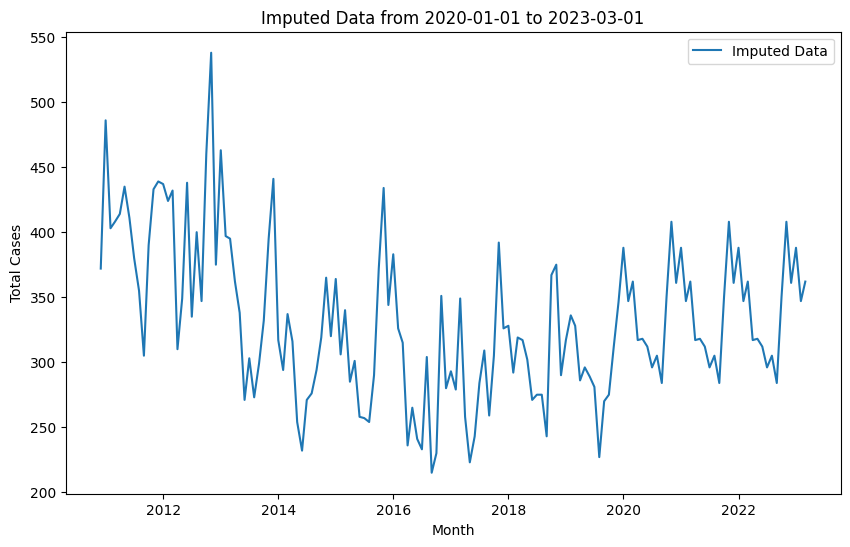

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzhf5k82o/07a4n51h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzhf5k82o/4xghaghn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66998', 'data', 'file=/tmp/tmpzhf5k82o/07a4n51h.json', 'init=/tmp/tmpzhf5k82o/4xghaghn.json', 'output', 'file=/tmp/tmpzhf5k82o/prophet_model_phgcj7k/prophet_model-20230519115235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:53:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


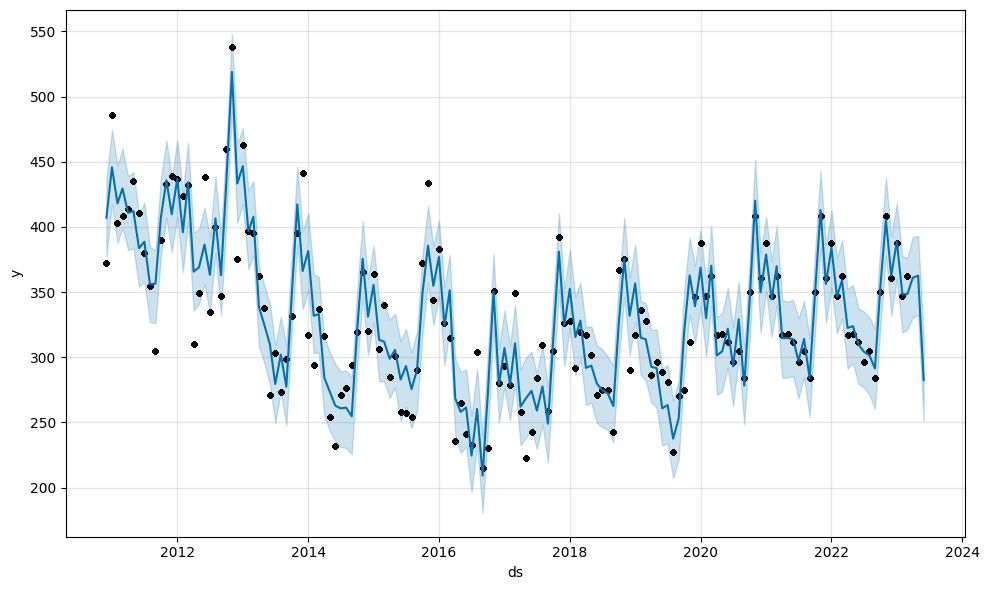

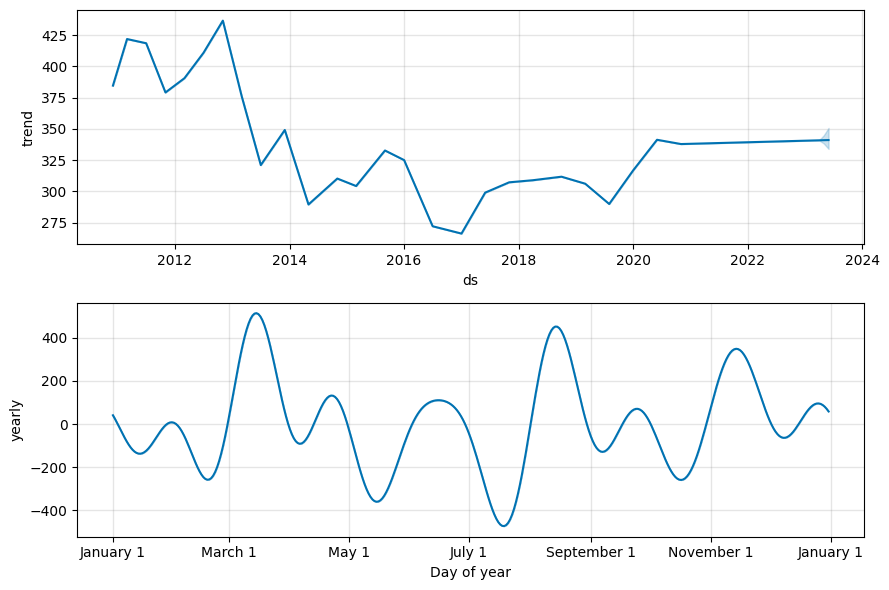

In [3]:
# Load the data
df = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/burglary.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df['Month_num'] = df['Month'].dt.month.astype(int)
df['year_num'] = df['Month'].dt.year.astype(int)

# Rename the columns
df = df.rename(columns={'Month_num': 'm', 'year_num': 'year'})

# create 'ds' and convert it to datetime format
df['ds'] = pd.to_datetime(df['m'].astype(str) + '-' + df['year'].astype(str), format='%m-%Y')
df = df[df['ds'] <  pd.to_datetime('2020-01-01')]

# prohpet_df = df.groupby('ds').size().reset_index(name='y')
# print(prohpet_df)

# create y
date_counts = df.groupby('ds').transform('count')
df["y"] = date_counts["year"]


# Create a new DataFrame that includes all months from 2020-01-01 to 2023-03-01
new_df2 = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', end='2023-03-01', freq='MS')})

# Calculate the weights based on the relative month of previous years
#new_df['weights'] = (pd.to_datetime(new_df['ds']).dt.month - 1) / 12


# Compute the  average for each month using data from previous years
new_df2['y'] = np.nan
for idx, row in new_df2.iterrows():
    month = row['ds'].month
    avg = df[df['ds'].dt.month == month]['y'].mean() #* (1 - row['weights'])
    avg = int(avg)
    new_df2.loc[idx, 'y'] = avg

new_df2['y'] = new_df2['y'].astype(int)

# Create a new DataFrame with expanded rows
expanded_df = pd.DataFrame()
for index, row in new_df2.iterrows():
    rows = pd.DataFrame({'ds': [row['ds']] * row['y'],
                         'y': [row['y']] * row['y']})
    expanded_df = pd.concat([expanded_df, rows], ignore_index=True)

# Concatenate the new DataFrame with the original DataFrame
imputed_df = pd.concat([df, expanded_df[['ds', 'y']]], axis=0)

# Reset the index of the concatenated DataFrame
imputed_df = imputed_df.reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(imputed_df['ds'], imputed_df['y'], label='Imputed Data')
plt.xlabel('Month')
plt.ylabel('Total Cases')
plt.title('Imputed Data from 2020-01-01 to 2023-03-01')
plt.legend()
plt.show()

#prophet dataframe
prohpet_df = imputed_df[['ds', 'y']]

# print(prohpet_df)
# print(prohpet_df.dtypes)

m = Prophet()
m.fit(prohpet_df)

future = m.make_future_dataframe(periods=3, freq='M')
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

fig2 = m.plot_components(forecast)

plot_plotly(m, forecast)
plot_components_plotly(m, forecast)